### Imports

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_seq_items', None)
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [160]:
np.set_printoptions(threshold=np.nan)

import warnings
import traceback

warnings.filterwarnings('ignore')
import argparse
import re
import sys, os

sys.path.append(os.getcwd())

import os
import requests
from requests.exceptions import ConnectionError

import bs4
from bs4 import BeautifulSoup
from fastnumbers import isfloat
from fastnumbers import fast_float
from multiprocessing.dummy import Pool as ThreadPool 
import more_itertools
from random import shuffle

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline
import json

import seaborn as sns
sns.set_style('whitegrid')





### Libs

In [4]:
def get_ci(p,t,r):
    return np.abs(np.fv(r/100,t,0,p))

def get_cumulative_amounts(p,t,r):
    psum = p
    for i in range(1,t):
        psum = psum + get_ci(p,i,r)
    return psum

def get_year_when_cumulative_profit_over_pe(pe,cpg):
    if np.isnan(pe) or np.isnan(cpg):
        return np.inf
    for i in range(1,int(np.ceil(pe))):
        if get_cumulative_amounts(1,i,cpg)>=pe:
            return i
    return int(np.ceil(pe))        

In [165]:
def is_dataframe(df):
    if df is not None and type(df)==pd.core.frame.DataFrame:
        return True
    return False

def ffloat(string):
    if string is None:
        return np.nan
    if type(string)==float or type(string)==int or type(string)==np.int64 or type(string)==np.float64:
        return string
    return fast_float(string.split(" ")[0].replace(',','').replace('%',''),default=np.nan)

def ffloat_list(string_list):
    return list(map(ffloat,string_list))


def get_children(html_content):
    return [item for item in html_content.children if type(item)==bs4.element.Tag]

def get_portfolio(mfid):
    url = "https://www.moneycontrol.com/india/mutualfunds/mfinfo/portfolio_holdings/"+mfid
    page_response = requests.get(url, timeout=240)
    page_content = BeautifulSoup(page_response.content, "html.parser")
    portfolio_table = page_content.find('table', attrs={'class': 'tblporhd'})
    fund_name = page_content.find('h1').text
    return portfolio_table,fund_name

def get_table(portfolio_table):
    portfolio_elems = get_children(portfolio_table)

    table_data = list()
    for row in portfolio_elems:
        row_data = list()
        row_elems = get_children(row)
        for elem in row_elems:
            text = elem.text.strip().replace("\n","")
            if len(text)==0:
                continue
            elem_descriptor = {'text':text}
            elem_children = get_children(elem)
            if len(elem_children)>0:
                if elem_children[0].has_attr('href'):
                    elem_href = elem_children[0]['href']
                    elem_descriptor['href'] = elem_href

            row_data.append(elem_descriptor)
        table_data.append(row_data)
    return table_data

def get_table_simple(portfolio_table,is_table_tag=True):
    portfolio_elems = portfolio_table.find_all('tr')
    table_data = list()
    for row in portfolio_elems:
        row_data = list()
        row_elems = get_children(row)
        #print(row_elems)
        for elem in row_elems:
            text = elem.text.strip().replace("\n","")
            if len(text)==0:
                continue
            row_data.append(text)
        table_data.append(row_data)
    return table_data

def get_inner_texts_as_array(elem,filter_empty=True):
    
    children = get_children(elem)
    tarr = [child.text.strip().replace("\n","") for child in children]
    if filter_empty:
        tarr = list(filter(lambda x:x is not None and len(x)>0,tarr))
    return tarr
        

In [167]:
def get_shareholding_pattern(shareholding_url):
    page_response = requests.get(shareholding_url, timeout=240)
    page_content = BeautifulSoup(page_response.content, "html.parser")
    tables = page_content.find_all('table')
    if len(tables)<3:
        return {}
    table_content = page_content.find_all('table')[2]
    rows = table_content.find_all('tr')
    all_tds = page_content.find_all('td')
    idx = list(map(lambda x:x.text,all_tds)).index("Total (A)+(B)+(C)")

    promoters = get_inner_texts_as_array(list(filter(lambda x:"Total shareholding of Promoter and Promoter Group (A)" in x.text,rows))[0],filter_empty=False)
    public = get_inner_texts_as_array(list(filter(lambda x:"Total Public shareholding (B)" in x.text,rows))[0],filter_empty=False)
    all_shares = get_inner_texts_as_array(list(filter(lambda x:"Total (A)+(B)+(C)" in x.text,page_content.find_all('tr')))[0],filter_empty=False)
    promoters_pledging = ffloat(promoters[7])
    
    promoters = ffloat(promoters[5])
    public = ffloat(public[5])
    total_shares_count = ffloat(all_tds[idx+2].text)
    total_pledging = ffloat(all_tds[idx+7].text)
    
    return {"promoters":promoters,"public":public,"promoters_pledging":promoters_pledging,
            "total_shares_count":total_shares_count,"total_pledging":total_pledging}

def get_fundholding_pattern(fundholding_url):
    # Funds holding it or not Y
    # Total funds holding currently N
    # percent held by funds
    # buys last quarter 
    # sells last quarter
    # no change last quarter
    # Total change in fund holding by money
    # Total change in fund holding by percent shares
    page_response = requests.get(fundholding_url, timeout=240)
    page_content = BeautifulSoup(page_response.content, "html.parser")
    results = {}
    top_tab = page_content.text
#     print(top_tab)
    if "Not held by Mutual Funds in the last 6 quarters" in top_tab:
        results['mf_holding'] = True
    else:
        results['mf_holding'] = False
    bought = np.nan
    sold = np.nan
    hold = np.nan
    if not results['mf_holding']:
        bl = top_tab.split("Bought by")
        if len(bl)==2:
            bought = ffloat(bl[1].strip().split(" ")[0])
            
        sl = top_tab.split("Sold by")
        if len(sl)==2:
            sold = ffloat(sl[1].strip().split(" ")[0])
        hl = top_tab.split("No change in")
        if len(hl)==2:
            hold = ffloat(hl[1].strip().split(" ")[0])
        
    results['mf_bought'] = bought
    results['mf_sold'] = sold
    results['mf_hold'] = hold
    
    six_quarter = page_content.find('div',attrs={'id':'div_0'}).find('table',attrs={'class':'tblfund2'}).find_all('tr')[-1]
    six_quarter = ffloat_list(get_inner_texts_as_array(six_quarter)[1:])
    results['mf_share_count'] = six_quarter[0]
    results['mf_share_count_last_quarter_change'] = six_quarter[0] - six_quarter[1]
    results['mf_six_quarter_share_count'] = six_quarter
    if not np.isnan(bought):
        bought_table = page_content.find('div',attrs={'id':'div_1'}).find('table')
    if not np.isnan(sold):
        sold_table = page_content.find('div',attrs={'id':'div_2'}).find('table')
    if not np.isnan(hold):
        hold_table = page_content.find('div',attrs={'id':'div_3'}).find('table')
    
    return results

In [169]:

def get_ratios(url):
    page_response = requests.get(url, timeout=240)
    page_content = BeautifulSoup(page_response.content, "html.parser")
    table_content = page_content.find_all('table',attrs={'class':'table4'})[-1]
    if "Data Not Available" in table_content.text:
         return {}
    dates_html = get_children(get_children(get_children(table_content)[0])[1])[1]
    
    dates = get_inner_texts_as_array(dates_html)
    
    ratios_htmls = get_children(get_children(get_children(get_children(table_content)[0])[1])[2])[1:]
        
    rows = list(map(get_inner_texts_as_array,ratios_htmls))
    ratios = {}
    ratios['dates'] = dates
    
    for row in rows:
        if len(row)>1:
            ratios[row[0]] = ffloat_list(row[1:])
    
    needed_keys = [('dates','ratios_dates'),
                   ('Diluted EPS (Rs.)','ratios_diluted_eps'),
                   ('Revenue from Operations/Share (Rs.)','ratios_revenue_per_share'),
                   ('PBT/Share (Rs.)','ratios_pbt_per_share'),
                   ('PBT Margin (%)','ratios_pbt_margin_per_share'),
                   ('Total Debt/Equity (X)','ratios_de'),
                   ('Asset Turnover Ratio (%)','ratios_asset_turnover_ratio'),
                   ('Current Ratio (X)','ratios_cr'),
                   ('EV/EBITDA (X)','ratios_ev_by_ebitda'),
                   ('Price/BV (X)','ratios_pb')]
    
    ratios = { your_key[1]: ratios[your_key[0]] if your_key[0] in ratios else [] for your_key in needed_keys }
    return ratios

In [8]:
def get_min_and_three_year_from_screener(table):
    min_value = np.inf
    three_year_value = np.inf
    for row in table:
        if len(row)==2:
            if row[0]=='3 Years:':
                three_year_value = ffloat(row[1].replace('%',''))
            cur_value = ffloat(row[1].replace('%',''))
            min_value = min(min_value,cur_value)
    return min_value,three_year_value

def get_quarterly_results(quarterly_results_table):
    qrt = get_table_simple(quarterly_results_table)
    qres = {}
    qres['dates'] = qrt[0]
    qres['sales'] = ffloat_list(qrt[1][1:])
    qres['operating_profit'] = ffloat_list(qrt[3][1:])
    qres['opm_percent'] = ffloat_list(qrt[4][1:])
    qres['interest'] = ffloat_list(qrt[7][1:])
    qres['pbt'] = ffloat_list(qrt[8][1:])
    return qres

def get_annual_results(annual_results):
    if annual_results is None:
        return {}
    qrt = get_table_simple(annual_results)
    qres = {}
    qres['dates'] = qrt[0]
    qres['sales'] = ffloat_list(qrt[1][1:])
    qres['operating_profit'] = ffloat_list(qrt[3][1:])
    qres['opm_percent'] = ffloat_list(qrt[4][1:])
    qres['interest'] = ffloat_list(qrt[6][1:])
    qres['pbt'] = ffloat_list(qrt[8][1:])
    qres['eps'] = ffloat_list(qrt[11][1:])
    return qres

def get_balance_sheet(balance_sheet):
    if balance_sheet is None:
        return {}
    qrt = get_table_simple(balance_sheet)
    qres = {}
    qres['dates'] = qrt[0]
    qres['borrowings'] = ffloat_list(qrt[3][1:])
    qres['fixed_assets'] = ffloat_list(qrt[6][1:])
    qres['total_assets'] = ffloat_list(qrt[10][1:])
    return qres

def get_cash_flows(cash_flows):
    if cash_flows is None:
        return {}
    qrt = get_table_simple(cash_flows)
    qres = {}
    qres['dates'] = qrt[0]
    qres['net_cash_flow'] = ffloat_list(qrt[4][1:])
    return qres

In [9]:


def get_past_prices(sc_id):
    bse_url = "https://www.moneycontrol.com/tech_charts/bse/his/%s.csv"%sc_id
    nse_url = "https://www.moneycontrol.com/tech_charts/nse/his/%s.csv"%sc_id
    
    past_prices_nse = pd.read_csv(nse_url,header=None,names=['open','high','low','close','volume',1,2,3,4])[['open','high','low','close','volume']]
    past_prices_nse.index = pd.to_datetime(past_prices_nse.index)
    
    past_prices_bse = pd.read_csv(bse_url,header=None,names=['open','high','low','close','volume',1,2,3,4])[['open','high','low','close','volume']]
    past_prices_bse.index = pd.to_datetime(past_prices_bse.index)
    
    ly = None
    two_year_ago = None
    three_year_ago = None
    five_year_ago = None
    past_prices = past_prices_bse
    for i in range(12):
        try:
            if ly is None:
                ly_t = pd.to_datetime(past_prices.iloc[-1:].index.values[0] - pd.to_timedelta(364+i, unit='d'))
                ly = past_prices.loc[[ly_t]]
            if two_year_ago is None:
                two_year_ago_t = pd.to_datetime(past_prices.iloc[-1:].index.values[0] - pd.to_timedelta(730+i, unit='d'))
                two_year_ago = past_prices.loc[[two_year_ago_t]]
            if three_year_ago is None:
                three_year_ago_t = pd.to_datetime(past_prices.iloc[-1:].index.values[0] - pd.to_timedelta(1095+i, unit='d'))
                three_year_ago = past_prices.loc[[three_year_ago_t]]
            if five_year_ago is None:
                five_year_ago_t = pd.to_datetime(past_prices.iloc[-1:].index.values[0] - pd.to_timedelta(1825+i, unit='d'))
                five_year_ago = past_prices.loc[[five_year_ago_t]]
        except Exception as e:
            pass
       
    past_prices = past_prices_nse
    for i in range(12):
        try:
            if ly is None:
                ly_t = pd.to_datetime(past_prices.iloc[-1:].index.values[0] - pd.to_timedelta(364+i, unit='d'))
                ly = past_prices.loc[[ly_t]]
            if two_year_ago is None:
                two_year_ago_t = pd.to_datetime(past_prices.iloc[-1:].index.values[0] - pd.to_timedelta(730+i, unit='d'))
                two_year_ago = past_prices.loc[[two_year_ago_t]]
            if three_year_ago is None:
                three_year_ago_t = pd.to_datetime(past_prices.iloc[-1:].index.values[0] - pd.to_timedelta(1095+i, unit='d'))
                three_year_ago = past_prices.loc[[three_year_ago_t]]
            if five_year_ago is None:
                five_year_ago_t = pd.to_datetime(past_prices.iloc[-1:].index.values[0] - pd.to_timedelta(1825+i, unit='d'))
                five_year_ago = past_prices.loc[[five_year_ago_t]]
        except Exception as e:
            pass
    
    if len(past_prices_nse)>=len(past_prices_bse):
        past_prices = past_prices_nse
    else:
        past_prices = past_prices_bse
    res = {"all_past_prices":past_prices,"last_year":ly,"two_year_ago":two_year_ago,
            "three_year_ago":three_year_ago,"five_year_ago":five_year_ago}
    return res

### Lib for fetching

In [171]:

def get_scrip_info(url):
    original_url = url
    key_val_pairs = {}
    key_val_pairs["original_url"] = original_url
    if not url.startswith("http"):
        url = "https://www.moneycontrol.com"+url
    try:
        page_response = requests.get(url, timeout=240)
        page_content = BeautifulSoup(page_response.content, "html.parser")
        scrip_name = None
        name_divs = page_content.find_all('div',attrs={'class':'gry10'})
        for nd in name_divs:
            texts = list(map(lambda x:x.strip(),nd.text.split(" ")))
            if "NSE:" in texts:
                scrip_name = texts[texts.index("NSE:")+1]
                scrip_name = re.sub('[^0-9a-zA-Z&\-]+', '', scrip_name)
        if scrip_name is None or len(scrip_name.strip())==0 or "ETF" in scrip_name:
            key_val_pairs['failure'] = True
            key_val_pairs['err'] = "%s is not named on NSE"%url
            #print(key_val_pairs['err'])
            return key_val_pairs
        
        content_div_text = page_content.find('div',attrs={'id':'content_full'}).text
        if "not listed" in content_div_text or "not traded" in content_div_text:
            key_val_pairs['failure'] = True
            key_val_pairs['err'] = "%s is not listed on both BSE and NSE"%url
            #print(key_val_pairs['err'])
            return key_val_pairs
        price = ffloat(page_content.find('div',attrs={'id':'Nse_Prc_tick_div'}).text.split(" ")[0].replace(',',''))
        name = page_content.find('h1',attrs={'class':'company_name'}).text
        
        screener_url = "https://www.screener.in/company/%s/"%scrip_name
        screener_page_response = requests.get(screener_url, timeout=240)
        
        if screener_page_response.status_code>299:
            key_val_pairs['failure'] = True
            key_val_pairs['err'] = "No Screener URL: %s"%screener_url
            #print(key_val_pairs['err'])
            return key_val_pairs
        screener_page_content = BeautifulSoup(screener_page_response.content, "html.parser")
        screener_name = get_children(get_children(screener_page_content.find('nav',attrs={'id':'fixed-scroll-aid-bar'}))[0])[0].text.strip()

        sector = get_children(screener_page_content.find('h1'))[0].text.replace("/",'').strip()
        yearly_high = page_content.find('span',attrs={'id':'n_52high'}).text.strip()
        yearly_low = page_content.find('span',attrs={'id':'n_52low'}).text.strip()
        html_data_content = page_content.find('div', attrs={'id': 'mktdet_1'})
        petable = get_table(get_children(html_data_content)[0])
        pbtable = get_table(get_children(html_data_content)[1])
        
        
        dma_table = get_table_simple(page_content.find('div',attrs={'id':'acc_hd2'}).find_all('table')[2])
        #print(dma_table)
        thirty_dma = None
        fifty_dma = None
        one_fifty_dma = None
        two_hundred_dma = None
        if len(dma_table[1])>1:
            thirty_dma = dma_table[1][1]
        if len(dma_table[2])>1:
            fifty_dma = dma_table[2][1]
        if len(dma_table[3])>1:
            one_fifty_dma = dma_table[3][1]
        if len(dma_table[4])>1:
            two_hundred_dma = dma_table[4][1]
        
        
        side_nav = page_content.find('dl',attrs={'id':'slider'})
        ratio_url = side_nav.find_all('dd')[2].find_all('a')[7]['href']
        ratio_url = "https://www.moneycontrol.com"+ratio_url
        ratios = get_ratios(ratio_url)
        
        
        volume = ffloat(page_content.find('span',attrs={'id':'nse_volume'}).text)
        
        sc_id = page_content.find('input',attrs={'id':'sc_id'}).get('value').lower()
        
        mf_url = "https://www.moneycontrol.com/mf/user_scheme/mfholddetail_sec.php?sc_did=%s"%sc_id
        shareholding_url = "https://www.moneycontrol.com"+side_nav.find_all('dd')[4].find_all('a')[0]['href']
        shareholdings = get_shareholding_pattern(shareholding_url)
        mfs = get_fundholding_pattern(mf_url)
        
        key_val_pairs = {**key_val_pairs, **mfs, **shareholdings, **ratios}
        
        past_prices = get_past_prices(sc_id)
        
        l_yp = None
        two_yp = None
        three_yp = None
        five_yp = None
        gain_loss_l_yp = None
        gain_loss_two_yp = None
        gain_loss_three_yp = None
        gain_loss_five_yp = None
        
        if is_dataframe(past_prices['last_year']):
            l_yp = past_prices['last_year']['close'].values[0]
            gain_loss_l_yp = (price - l_yp)*100/l_yp
        if is_dataframe(past_prices['two_year_ago']):    
            two_yp = past_prices['two_year_ago']['close'].values[0]
            gain_loss_two_yp = (price - two_yp)*100/two_yp
        if is_dataframe(past_prices['three_year_ago']):
            three_yp = past_prices['three_year_ago']['close'].values[0]
            gain_loss_three_yp = (price - three_yp)*100/three_yp
        if is_dataframe(past_prices['five_year_ago']):
            five_yp = past_prices['five_year_ago']['close'].values[0]
            gain_loss_five_yp = (price - five_yp)*100/five_yp
        
        
        
        
        
        quarterly_results = get_quarterly_results(screener_page_content.find('section',attrs={'id':'quarters'}).find('table'))
        
        annual_results_table = screener_page_content.find('section',attrs={'id':'profit-loss'}).find('table',attrs={'class':'data-table'})
        annual_results = None
        if annual_results_table is not None:
            annual_results = get_annual_results(annual_results_table)
        
        csg_table = get_table_simple(screener_page_content.find('section',attrs={'id':'profit-loss'}).find_all('table',attrs={'class':'ranges-table'})[0])
        min_csg,three_year_csg = get_min_and_three_year_from_screener(csg_table)
        cpg_table = get_table_simple(screener_page_content.find('section',attrs={'id':'profit-loss'}).find_all('table',attrs={'class':'ranges-table'})[1])
        min_cpg,three_year_cpg = get_min_and_three_year_from_screener(cpg_table)
        roe_table = get_table_simple(screener_page_content.find('section',attrs={'id':'profit-loss'}).find_all('table',attrs={'class':'ranges-table'})[2])
        min_roe,three_year_roe = get_min_and_three_year_from_screener(roe_table)
        
        balance_sheet = get_balance_sheet(screener_page_content.find('section',attrs={'id':'balance-sheet'}).find('table'))
        cash_flows = get_cash_flows(screener_page_content.find('section',attrs={'id':'cash-flow'}).find('table'))

        data_table = list()
        data_table.extend(petable)
        data_table.extend(pbtable)

        consolidated_html_data_content = page_content.find('div', attrs={'id': 'mktdet_2'})
        consolidated_petable = get_table(get_children(consolidated_html_data_content)[0])
        consolidated_pbtable = get_table(get_children(consolidated_html_data_content)[1])
        consolidated_data_table = list()
        consolidated_data_table.extend(consolidated_petable)
        consolidated_data_table.extend(consolidated_pbtable)

        

        for row in consolidated_data_table:

            k = row[0]['text']
            if len(row)<2:
                v=None
            else:
                v = row[1]['text'].split(" ")[0].replace(',','')
            key_val_pairs[k]=v

        for row in data_table:

            k = row[0]['text']
            if len(row)<2:
                v=None
            else:
                v = row[1]['text'].split(" ")[0].replace(',','')

            if k not in key_val_pairs or not isfloat(key_val_pairs[k]):
                key_val_pairs[k]=v

        key_val_pairs["pe"] = ffloat(key_val_pairs.pop('P/E'))
        key_val_pairs["book_value"] = ffloat(key_val_pairs.pop('BOOK VALUE (Rs)'))
        key_val_pairs["deliverables"] = ffloat(key_val_pairs.pop('DELIVERABLES (%)'))
        key_val_pairs["eps"] = ffloat(key_val_pairs.pop('EPS (TTM)'))
        key_val_pairs["industry_pe"] = ffloat(key_val_pairs.pop('INDUSTRY P/E'))
        if 'MARKET CAP (Rs Cr)' in key_val_pairs:
            key_val_pairs["market_cap"] = key_val_pairs.pop('MARKET CAP (Rs Cr)')
        elif '**MARKET CAP (Rs Cr)' in key_val_pairs:
            key_val_pairs["market_cap"] = key_val_pairs.pop('**MARKET CAP (Rs Cr)')
        key_val_pairs["market_cap"] = ffloat(key_val_pairs["market_cap"])
        key_val_pairs["pb"] = ffloat(key_val_pairs.pop('PRICE/BOOK'))
        key_val_pairs["pc"] = ffloat(key_val_pairs.pop('P/C'))
        key_val_pairs['price'] = ffloat(price)
        key_val_pairs['volume'] = volume
        key_val_pairs["name"] = name
        key_val_pairs["scrip_name"] = scrip_name
        key_val_pairs["yearly_low"] = ffloat(yearly_low)
        key_val_pairs["yearly_high"] = ffloat(yearly_high)

        key_val_pairs["min_csg"] = min_csg
        key_val_pairs["three_year_csg"] = three_year_csg
        key_val_pairs["min_cpg"] = min_cpg
        key_val_pairs["three_year_cpg"] = three_year_cpg
        key_val_pairs["min_roe"] = min_roe
        key_val_pairs["three_year_roe"] = three_year_roe
        key_val_pairs["peg"] = ffloat(key_val_pairs["pe"])/three_year_cpg
        if np.isnan(three_year_cpg):
            key_val_pairs["peg"] = ffloat(key_val_pairs["pe"])/min_cpg
        key_val_pairs["min_recovery_year"] = get_year_when_cumulative_profit_over_pe(ffloat(key_val_pairs["pe"]),three_year_cpg)
        key_val_pairs['sector'] = sector
        key_val_pairs['thirty_dma'] = ffloat(thirty_dma)
        key_val_pairs['fifty_dma'] = ffloat(fifty_dma)
        key_val_pairs['one_fifty_dma'] = ffloat(one_fifty_dma)
        key_val_pairs['two_hundred_dma'] = ffloat(two_hundred_dma)
        
        key_val_pairs['l_yp'] = l_yp
        key_val_pairs['two_yp'] = two_yp
        key_val_pairs['three_yp'] = three_yp
        key_val_pairs['five_yp'] = five_yp
        key_val_pairs['gain_loss_l_yp'] = gain_loss_l_yp
        key_val_pairs['gain_loss_two_yp'] = gain_loss_two_yp
        key_val_pairs['gain_loss_three_yp'] = gain_loss_three_yp
        key_val_pairs['gain_loss_five_yp'] = gain_loss_five_yp
        
        key_val_pairs['de'] = np.nan
        key_val_pairs['ev_by_ebitda'] = np.nan
        if "ratios_ev_by_ebitda" in key_val_pairs and len(key_val_pairs["ratios_ev_by_ebitda"])>0:
            key_val_pairs['ev_by_ebitda'] = key_val_pairs["ratios_ev_by_ebitda"][0]
        
        if "ratios_de" in key_val_pairs and len(key_val_pairs["ratios_de"])>0:
            key_val_pairs['de'] = key_val_pairs["ratios_de"][0]
        key_val_pairs['quarterly_results'] = quarterly_results
        key_val_pairs['annual_results'] = annual_results
        
        key_val_pairs['balance_sheet'] = balance_sheet
        key_val_pairs['cash_flows'] = cash_flows
        key_val_pairs['past_prices'] = past_prices
        key_val_pairs['failure'] = False

        del key_val_pairs['DIV (%)']
        del key_val_pairs['DIV YIELD.(%)']
        del key_val_pairs['FACE VALUE (Rs)']
        del key_val_pairs['Market Lot']
    except Exception as e:
#         raise e
        traceback.print_exc()
        key_val_pairs['failure'] = True
        key_val_pairs['err'] = "Error for: %s"%original_url
        print(key_val_pairs['err'])
        return key_val_pairs
        
    return key_val_pairs






In [172]:
def get_scrip_info_by_nse_name(nse_name):
    url = "https://www.moneycontrol.com/mccode/common/autosuggesion.php?classic=true&query=%s&type=1&format=json"%nse_name
    page_response = requests.get(url, timeout=240)
    json_text = page_response.text
    data = json.loads(json_text)
    scrip_url = data[0]['link_src']
    return get_scrip_info(scrip_url)

### Company Analysis and Filtering 



#### Criterias - Current
- both NSE and BSE listing
- Not PSU
- Market Cap >= 200 Cr
- Low P/E, pe<20 in all cases, pe wrt to MarketCap and eps increase
- Low debt/Equity Ratio, de<1 in all cases
- P/B ratio
- Current Ratio > 1
- OPM % latest quarter > 10% 
- PEG < 3 , recovery by cumulative profit sum in less than 8 years
- Recovery years on investment by cumulative profits or by pure earnings < 10

#### Criterias - Over time 
- Increasing Sale YoY
- Decreasing d/e ratio YoY
- Increasing eps YoY
- No Steep Price increase in last 2 years

#### Criterias - Buy Now
- Below 30,100 DMA
- Low Volumes 

#### Find Good Companies from MF
- Use above criterias

If filter fails due to lack of data then let the Stock pass through

#### Actual P/E function

In [15]:
def get_pe_filter(params={"mcap":[1e2,1e3,5e3,1e4,2e4],"pe":[1,5,10,15,20],"mcap_lower_limit":1e2,"pe_upper_limit":25}):
    def filter_fn(stock_detail):
        x=params['mcap']
        y=params['pe']
        pe = ffloat(stock_detail['pe'])
        mcap = ffloat(stock_detail['market_cap'])
        
        if np.isnan(pe) or np.isnan(mcap):
            return False
        if pe>params['pe_upper_limit']:
            return False
        if mcap<params['mcap_lower_limit']:
            return False
        
        right = np.searchsorted(params['mcap'],mcap)
        
        
        if right==0:
            right=right+1
        
        if right==len(x):
            right=right-1
        
        left = right-1
        coefficients = np.polyfit([x[left],x[right]], [y[left],y[right]], 1)
        polynomial = np.poly1d(coefficients)
        pe_value = polynomial(mcap)
        if pe<=pe_value:
            return True
        return False
        
    return filter_fn

#### Testing for P/E and marketcap

In [16]:
pe_list = list()
pe_set = set()
pe_comparator = get_pe_filter()
for pe in [1,2,3,4,5,6,7,9,10,11,13]:
    for mcap in np.arange(1e2,2e3,1e2):
        if pe not in pe_set:
            if pe_comparator({"pe":pe,"market_cap":mcap}):
                pe_list.append({"mcap":mcap,"pe":pe})
                pe_set.add(pe)
pd.DataFrame.from_records(pe_list)

,mcap,pe
0,100.0,1
1,400.0,2
2,600.0,3
3,800.0,4
4,1000.0,5
5,1900.0,6


In [17]:
pe_list = list()
pe_set = set()
pe_comparator = get_pe_filter()
for pe in [1,3,7,9,10,11,13,15,17,18,19,20,21,22,25,30]:
    for mcap in np.arange(1e3,2e4,1e3):
        if pe not in pe_set:
            if pe_comparator({"pe":pe,"market_cap":mcap}):
                pe_list.append({"mcap":mcap,"pe":pe})
                pe_set.add(pe)
pd.DataFrame.from_records(pe_list)


,mcap,pe
0,1000.0,1
1,1000.0,3
2,3000.0,7
3,5000.0,9
4,6000.0,10
5,6000.0,11
6,8000.0,13
7,10000.0,15
8,14000.0,17
9,16000.0,18


#### P/B and Book_value>0

In [18]:
def get_pb_filter(params={"mcap":[1e2,5e2,1e3,2e3,6e3],"pb":[1,2,3,4,5],"pb_upper_limit":5}):
    def filter_fn(stock_detail):
        x=params['mcap']
        y=params['pb']
        pb = ffloat(stock_detail['pb'])
        bv = ffloat(stock_detail['book_value'])
        mcap = ffloat(stock_detail['market_cap'])
        
        if np.isnan(pb) or np.isnan(bv) or pb>params['pb_upper_limit'] or bv<0:
            return False
        
        if pb>params['pb_upper_limit']:
            return False
        
        right = np.searchsorted(params['mcap'],mcap)
        
        
        if right==0:
            right=right+1
        
        if right==len(x):
            right=right-1
        
        left = right-1
        coefficients = np.polyfit([x[left],x[right]], [y[left],y[right]], 1)
        polynomial = np.poly1d(coefficients)
        pb_value = polynomial(mcap)
        if pb<=pb_value:
            return True
        return False
        
    return filter_fn

#### Test PB

In [19]:
pb_list = list()
pb_comparator_test = get_pb_filter()
pb_set = set()
for pb in [1,1.5,2,2.5,3,4]:
    for mcap in np.arange(1e2,2e3,1e2):
        if pb not in pb_set:
            if pb_comparator_test({'market_cap':mcap,"pb":pb,"book_value":10}):
                pb_list.append({"mcap":mcap,"pb":pb})
                pb_set.add(pb)
pd.DataFrame.from_records(pb_list)

,mcap,pb
0,200.0,1.0
1,400.0,1.5
2,600.0,2.0
3,800.0,2.5
4,1000.0,3.0


In [20]:
pb_comparator_test = get_pb_filter()
pb_list = list()
pb_set = set()
for pb in [1,2,3,4,4.5,5]:
    for mcap in np.arange(1e3,2e4,1e3):
        if pb not in pb_set:
            if pb_comparator_test({'market_cap':mcap,"pb":pb,"book_value":10}):
                pb_list.append({"mcap":mcap,"pb":pb})
                pb_set.add(pb)
pd.DataFrame.from_records(pb_list)

,mcap,pb
0,1000.0,1.0
1,1000.0,2.0
2,1000.0,3.0
3,2000.0,4.0
4,4000.0,4.5
5,6000.0,5.0


#### Profitability filter

In [21]:
def get_profitability_filter(params={"peg_lower_limit":0,"peg_upper_limit":3,
                                     "min_recovery_year":15,"min_cpg_lower_limit":0}):
    def filter_fn(stock_detail):
        peg = ffloat(stock_detail['peg'])
        min_cpg = ffloat(stock_detail['min_cpg'])
        min_recovery_year = ffloat(stock_detail['min_recovery_year'])
        
        if np.isnan(peg) or np.isnan(min_cpg) or np.isnan(min_recovery_year):
            return False
        
        if peg<=params['peg_upper_limit'] and peg>=params['peg_lower_limit'] and min_recovery_year<=params['min_recovery_year'] and min_cpg>params['min_cpg_lower_limit']:
            return True
        return False
        
    return filter_fn

#### Generic Filter one variable upper lower limits

In [22]:
def get_generic_filter(param_name,lower_limit=None,upper_limit=None,
                                     replacement_nan=None,replacement_not_present=None):
    def filter_fn(stock_detail):
        param = replacement_not_present
        if param_name in stock_detail:
            param = ffloat(stock_detail[param_name])
            
        if np.isnan(param):
            param = replacement_nan
        
        if param is None or np.isnan(param):
            return False
        
        if param<=upper_limit and param>=lower_limit:
            return True
        return False
        
    return filter_fn

In [23]:
def get_generic_filter_two_variables(x,y,xvar_name,yvar_name,accept_lower=True,
                                     pass_not_found=False):
    def filter_fn(stock_detail):
        if x is None or y is None or xvar_name is None or yvar_name is None:
            raise ValueError("Incorrect Parameters")
        
        if xvar_name not in stock_detail or yvar_name not in stock_detail:
            return pass_not_found
        
        xval=stock_detail[xvar_name]
        yval=stock_detail[yvar_name]
        
        
        right = np.searchsorted(xvar,xval)
        
        
        if right==0:
            right=right+1
        
        if right==len(x):
            right=right-1
        
        left = right-1
        coefficients = np.polyfit([x[left],x[right]], [y[left],y[right]], 1)
        polynomial = np.poly1d(coefficients)
        yt_value = polynomial(xval)
        if yval<=yt_value == accept_lower:
            return True
            
        
        return False
        
    return filter_fn

#### Getting All Company Links from MoneyControl

In [173]:


def get_stock_urls_from_listing_page(listing_page):
    page_response = requests.get(listing_page, timeout=240)
    page_content = BeautifulSoup(page_response.content, "html.parser")
    urls_table = page_content.find('table',attrs={'class':'pcq_tbl'})
    links = list(map(lambda x:get_children(x)[0]['href'],urls_table.find_all('td')))
    return links

def get_all_links(threadpool_size=8):
    abc = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    letters = [letter for letter in abc]
    listing_page_urls = ['https://www.moneycontrol.com/india/stockpricequote/'+letter for letter in letters]
    pool = ThreadPool(threadpool_size)
    all_links = list(more_itertools.flatten(pool.map(get_stock_urls_from_listing_page, listing_page_urls)))
    return all_links

In [122]:
def get_all_company_details(accumulator={},failures=[],size=10000,start=None,end=None,
                            threadpool_size=8,ignore_failures=True,
                            ignore_success=True,randomize=False):
    # filters is a list of functions returning T/F, They are always
    batch_size = 5*threadpool_size
    all_links = list(set(get_all_links()))
    print("Total Number of links = %s"%(len(all_links)))
    if ignore_success:
        all_links = list(set(all_links) - set([scrip['original_url'] for scrip in accumulator.values()]))
    if ignore_failures:
        all_links = list(set(all_links) - set([scrip['original_url'] for scrip in failures]))
    print("Total Links after removing success and failures = %s"%(len(all_links)))
    all_links = sorted(all_links)
    if start is not None and end is not None:
        all_links = all_links[start:end]
    all_links = all_links[:size]
    if randomize:
        shuffle(all_links)
    
    print("Total Links To Process = %s"%(len(all_links)))
    pool = ThreadPool(threadpool_size)
    batches = int(np.ceil(len(all_links)/batch_size))
    
    for batch_num in range(batches):
        start = batch_num*batch_size
        end = min((batch_num+1)*batch_size,len(all_links))
        print("start = %s, end = %s"%(start,end))
        this_batch = all_links[start:end]
        scrip_details = pool.map(get_scrip_info, this_batch)
        scrip_details = list(filter(lambda x:x is not None,scrip_details))
        fails = list(filter(lambda x:x['failure'],scrip_details))
        scrip_details = list(filter(lambda x:not x['failure'],scrip_details))
        for scrip in scrip_details:
            accumulator[scrip['scrip_name']] = scrip
        failures.extend(fails)
        failures = {failure['original_url']:failure for failure in failures}
        failures = list(failures.values())

In [83]:
accumulator={}

In [84]:
failures = []

In [ ]:

get_all_company_details(accumulator,failures,size=10000,start=3840,end=4080,
                        threadpool_size=48,ignore_failures=False);

In [29]:
len(accumulator.keys())
len(failures)

1582

6794

#### Write to File

In [204]:

import dill
with open('stock_results.pkl', 'wb') as f:
    dill.dump(accumulator, f)
    dill.dump(failures, f)

### Read from File and Filter

In [24]:
import dill
with open('stock_results.pkl', 'rb') as f:
    accumulator = dill.load(f)
    failures = dill.load(f)

In [25]:
def filter_companies(all_scrips,filters=[]):
    scrip_details = list(all_scrips.values())
    
    for i in range(len(filters)):
        scrip_details = list(filter(filters[i],scrip_details))
    
    return scrip_details
    
    

In [26]:
def get_df_from_scrip_details(scrip_details):
    other_cols = ['name','scrip_name']
    numeric_cols = ['book_value', 'price','deliverables', 'eps', 'industry_pe', 
                    'market_cap', 'pb', 'pc', 'pe','de',
                   'yearly_high','yearly_low','min_csg','three_year_csg','min_cpg','three_year_cpg',
                   'min_roe','three_year_roe','peg','min_recovery_year',
                    'l_yp','two_yp','three_yp','five_yp','gain_loss_l_yp','gain_loss_two_yp',
                   'gain_loss_three_yp']
    
    
    all_cols = other_cols+numeric_cols
    scrip_details = [{ your_key: scrip[your_key] for your_key in all_cols } for scrip in scrip_details]
    scrip_details = pd.DataFrame.from_records(scrip_details)
    scrip_details[numeric_cols] = scrip_details[numeric_cols].applymap(ffloat)
    scrip_details = scrip_details[all_cols]
    return scrip_details

In [27]:
pe_filter = get_pe_filter(params={"mcap":[1e2,1e3,5e3,1e4,2e4],"pe":[1,6,11,17,22],"mcap_lower_limit":1e2,
                                  "pe_upper_limit":25})
pb_filter = get_pb_filter(params={"mcap":[1e2,5e2,1e3,2e3,6e3],"pb":[1,3,4,5,6],"pb_upper_limit":6})
profitability_filter = get_profitability_filter(params={"peg_lower_limit":0,"peg_upper_limit":4,
                                     "min_recovery_year":15,"min_cpg_lower_limit":0})
filtered_companies = filter_companies(accumulator,filters=[pe_filter,pb_filter,profitability_filter])


In [28]:
de_filter = get_generic_filter("de",-1,2,0,0)
filtered_companies = filter_companies(accumulator,filters=[pe_filter,pb_filter,profitability_filter,de_filter])

In [29]:
get_df_from_scrip_details(filtered_companies)

,name,scrip_name,book_value,price,deliverables,eps,industry_pe,market_cap,pb,pc,pe,de,yearly_high,yearly_low,min_csg,three_year_csg,min_cpg,three_year_cpg,min_roe,three_year_roe,peg,min_recovery_year,l_yp,two_yp,three_yp,five_yp,gain_loss_l_yp,gain_loss_two_yp,gain_loss_three_yp
0,Bajaj Auto Ltd.,BAJAJ-AUTO,705.86,2618.50,33.06,152.89,19.75,75792.46,3.71,15.99,17.13,0.00,3468.35,2605.00,4.70,5.20,6.32,11.83,22.63,26.29,1.448014,10,2838.05,2700.00,2497.45,2002.50,-7.735945,-3.018519,4.846944
1,Hero Motocorp Ltd.,HEROMOTOCO,604.11,3136.75,39.27,185.14,19.75,62663.46,5.19,14.73,16.95,NaN,4091.95,3033.75,5.32,5.32,8.35,15.86,32.46,35.19,1.068726,9,3717.75,3279.70,2738.20,1757.75,-15.627732,-4.358630,14.555182
2,Ashok Leyland Ltd.,ASHOKLEY,28.10,112.05,24.78,6.21,32.47,32858.75,3.98,13.82,18.03,0.07,167.50,98.60,15.21,24.18,27.05,82.44,14.88,21.88,0.218705,5,106.15,96.15,80.60,14.50,5.558172,16.536661,39.019851
3,Yes Bank Ltd.,YESBANK,111.66,369.75,32.39,18.32,33.95,85242.34,3.31,19.13,20.17,NaN,394.35,285.00,19.57,20.54,26.56,28.19,17.67,18.51,0.715502,8,342.51,236.50,161.73,76.67,7.953052,56.342495,128.621777
4,Gujarat Alkalies and Chemicals Ltd.,GUJALKALI,529.73,503.40,38.09,72.85,8.81,3693.88,0.95,5.58,6.90,0.09,935.00,380.55,2.97,2.97,3.66,18.40,9.66,9.66,0.375000,5,412.70,266.80,171.00,182.50,21.977223,88.680660,194.385965
5,HCL Technologies Ltd.,HCLTECH,299.22,952.60,65.75,62.63,23.32,132619.78,3.18,13.12,15.21,0.00,1108.00,824.85,5.40,5.40,5.17,5.17,28.80,28.80,2.941973,12,891.45,737.90,954.30,449.70,6.859611,29.096083,-0.178141
6,Infosys Ltd.,INFY,297.27,1373.25,55.43,73.97,23.32,300361.18,4.63,16.67,18.59,NaN,1393.80,860.00,7.00,9.40,10.02,10.02,22.77,22.77,1.855289,12,993.75,1080.50,1089.35,726.90,38.188679,27.093938,26.061413
7,Tech Mahindra Ltd.,TECHM,197.85,632.05,48.16,38.76,23.32,61945.73,3.19,12.68,16.30,0.01,729.50,374.25,2.14,7.28,16.20,20.16,21.06,21.28,0.808532,8,389.10,508.40,510.90,301.58,62.438962,24.321400,23.713055
8,Vakrangee Ltd.,VAKRANGEE,19.40,49.20,39.18,6.43,23.32,5204.02,2.53,7.60,7.64,0.07,515.00,30.85,23.91,26.18,26.71,37.64,27.07,30.95,0.202976,5,219.18,96.03,81.45,39.40,-77.552696,-48.766011,-39.594843
9,Dilip Buildcon Ltd.,DBL,169.11,728.00,77.57,45.35,26.63,9973.94,4.31,11.14,16.08,1.19,1247.50,492.75,30.08,30.08,22.91,22.91,22.76,22.76,0.701877,8,527.40,NaN,NaN,NaN,38.035647,NaN,NaN


In [162]:
def score_company_on_filters(all_scrips,filters={}):
    all_scrips = list(all_scrips.values())
    other_cols = ['name','scrip_name']
    numeric_cols = ['price', 'industry_pe', 
                    'market_cap', 'pb', 'pe','de',
                   'yearly_high','yearly_low','three_year_csg','three_year_cpg',
                   'peg','min_recovery_year',
                    'l_yp','three_yp','five_yp']
    all_cols = other_cols+list(filters.keys())+numeric_cols
    scrip_details = []
    for scrip in all_scrips:
        for key in filters.keys():
            scrip[key] = filters[key](scrip)
        scrip_detail = { your_key: scrip[your_key] for your_key in all_cols }
        
        scrip_details.append(scrip_detail)
        
    scrip_details = pd.DataFrame.from_records(scrip_details)
    scrip_details[numeric_cols] = scrip_details[numeric_cols].applymap(ffloat)
    scrip_details = scrip_details[all_cols]
    return scrip_details
    

In [163]:
scores_df = score_company_on_filters(accumulator,filters={"pe_filter":pe_filter,"pb_filter":pb_filter,
                                              "profitability_filter":profitability_filter,"de_filter":de_filter})

In [164]:
scores_df.shape

(1582, 21)

In [165]:
scores_df.head(10)

,name,scrip_name,pe_filter,pb_filter,profitability_filter,de_filter,price,industry_pe,market_cap,pb,pe,de,yearly_high,yearly_low,three_year_csg,three_year_cpg,peg,min_recovery_year,l_yp,three_yp,five_yp
0,Carborundum Universal Ltd.,CARBORUNIV,False,True,True,True,350.25,41.90,6710.89,4.13,31.11,0.00,427.0,313.00,10.48,18.49,1.682531,12.000000,347.10,173.60,113.30
1,Grindwell Norton Ltd.,GRINDWELL,False,True,False,True,509.45,41.90,5557.04,5.54,37.12,NaN,588.8,361.25,9.50,10.58,3.508507,16.000000,426.20,365.88,111.78
2,Orient Abrasives Ltd.,ORIENTABRA,False,False,False,True,29.65,41.90,354.13,29.60,20.85,0.29,67.4,26.70,8.03,-1.03,-20.242718,21.000000,31.20,26.50,21.00
3,Wendt (India) Ltd.,WENDT,False,False,False,True,2893.25,41.90,577.75,4.75,44.00,NaN,4270.0,2275.00,6.56,-6.16,-7.142857,44.000000,2525.30,2029.50,1008.00
4,Adani Green Energy Ltd.,ADANIGREEN,False,True,False,False,52.90,10.97,8218.90,5.76,NaN,2.21,56.4,22.80,NaN,NaN,NaN,inf,NaN,NaN,NaN
5,Century Extrusions Ltd.,CENTEXT,False,False,False,True,6.05,14.23,47.60,1.10,11.90,0.91,7.9,3.40,-1.52,NaN,-0.942948,inf,4.96,1.18,1.03
6,Hindalco Industries Ltd.,HINDALCO,False,True,False,True,206.55,21.26,46376.18,1.01,32.27,0.48,284.0,192.35,9.87,-5.66,-5.701413,33.000000,221.20,109.05,103.25
7,Maan Aluminium Ltd.,MAANALU,False,False,True,False,123.80,21.26,84.20,2.83,13.11,2.29,182.0,68.00,49.89,93.94,0.139557,4.000000,88.75,17.95,NaN
8,Manaksia Aluminium Company Ltd.,MANAKALUCO,False,True,False,True,6.55,21.26,43.25,0.44,34.47,0.83,19.0,5.75,10.39,NaN,0.279313,inf,6.79,4.90,NaN
9,National Aluminium Company Ltd.,NATIONALUM,True,True,False,True,62.15,21.26,12003.49,1.04,8.95,0.01,97.6,56.55,3.61,5.31,1.685499,8.000000,70.55,37.20,30.05


### Plotting and Analysis

TODO:

- Risk Analysis
- Analyze/get stocks from MF
- Cluster Analysis
    - seeing if we can cluster stocks which had good growth in past without taking their price growths
    - Analysis of various sectors overall growth based on mcap.

#### PE vs MarketCap Corr

(1, 50)

(10000, 800000)

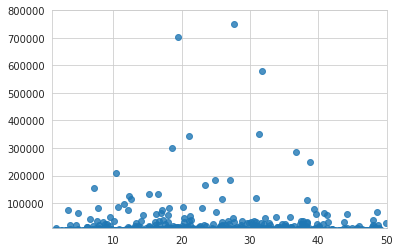

In [93]:
pe_list = []
mcap_list = []
for key in accumulator.keys():
    prices_df = accumulator[key]['past_prices']['all_past_prices']
    pe = accumulator[key]['pe']
    mcap = accumulator[key]['market_cap']
    pe_list.append(pe)
    mcap_list.append(mcap)
    
ax = sns.regplot(x=np.array(pe_list), y=np.array(mcap_list),fit_reg=False)
ax.set_xlim([1,50])
ax.set_ylim([10000,800000])
plt.show()

#### Price Volume Charts

In [161]:

def generate_price_volume_chart(stock_df,name,days=1095,ewmas=[],other_technical_indicators=[]):
    plt.figure(figsize=(16,8))
    top = plt.subplot2grid((6,6), (0, 0), rowspan=4, colspan=6)
    bottom = plt.subplot2grid((6,6), (4,0), rowspan=2, colspan=6)
    ts_df = stock_df.tail(days)
    handles = []
    p1, = top.plot(ts_df.index, ts_df['close'],label="price")
    handles.append(p1)
    for ewma in ewmas:
        y = ts_df['close'].ewm(span=ewma).mean()
        p2, = top.plot(ts_df.index, y,label="%s day ewma"%ewma)
        handles.append(p2)
    top.legend(handles=handles)
    bottom.bar(ts_df.index, ts_df['volume']) 
    bottom.set_ylim([ts_df['volume'].min(),ts_df['volume'].max()])
#     sns.lineplot(x="index", y="close", data=ts_df.reset_index(),ax=top)
#     sns.barplot(x="index", y="volume", data=ts_df.reset_index(),ax=bottom)

    # set the labels
    top.axes.get_xaxis().set_visible(False)
    top.set_title(name)
    top.set_ylabel('Closing Price')
    bottom.set_ylabel('Volume')
    
    plt.show()

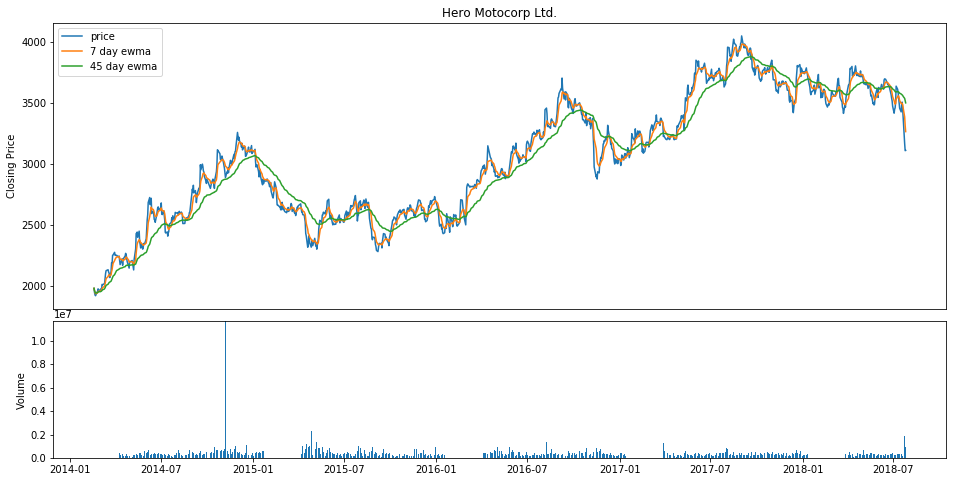

In [70]:
generate_price_volume_chart(accumulator['HEROMOTOCO']['past_prices']['all_past_prices'],accumulator['HEROMOTOCO']['name'],days=1095,ewmas=[7,45])

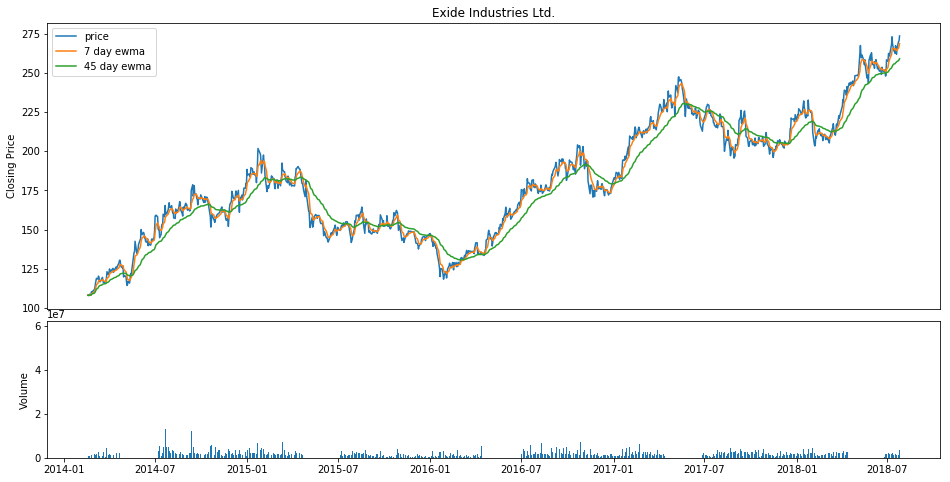

In [74]:
generate_price_volume_chart(accumulator['EXIDEIND']['past_prices']['all_past_prices'],accumulator['EXIDEIND']['name'],days=1095,ewmas=[7,45])


#### Returns analysis

In [162]:

def generate_returns_chart(stocks,days=1095):
    plt.figure(figsize=(16,8))
    stocks = {key:stocks[key].tail(days).apply(lambda x: x / x[0]) for key in stocks.keys()}
    handles = []
    for key in stocks.keys():
        y = stocks[key]['close']
        p2, = plt.plot(stocks[key].index, y,label=key)
        handles.append(p2)
    plt.legend(handles=handles)
    plt.title("Comparative returns")
    plt.ylabel('Comparative Returns')
    
    plt.show()

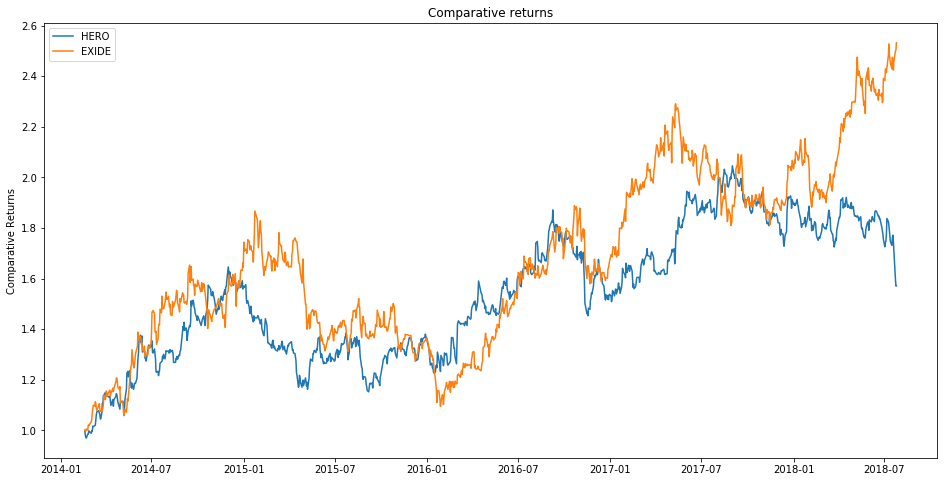

In [80]:
generate_returns_chart({"HERO":accumulator['HEROMOTOCO']['past_prices']['all_past_prices'],
                       "EXIDE":accumulator['EXIDEIND']['past_prices']['all_past_prices']})

#### Volatility analysis

In [230]:
def generate_percent_change_chart(stocks,days=1095):
    plt.figure(figsize=(16,8))
    stocks = {key:stocks[key].tail(days).pct_change()*100 for key in stocks.keys()}
    handles = []
    for key in stocks.keys():
        stocks[key]['name'] = key
        y = stocks[key]['close']
        p2, = plt.plot(stocks[key].index, y,label=key)
        handles.append(p2)
    all_stocks = pd.concat(list(stocks.values()))
    plt.legend(handles=handles)
    plt.title("Daily Percent Changes Chart")
    plt.ylabel('Daily Percent Changes')
    plt.show()
    fig, ax = plt.subplots(figsize=(16,8))
    sns.boxplot(x="name", y="close", data=all_stocks,ax=ax);
    ax.xaxis.set_tick_params(rotation=90)
    plt.show()

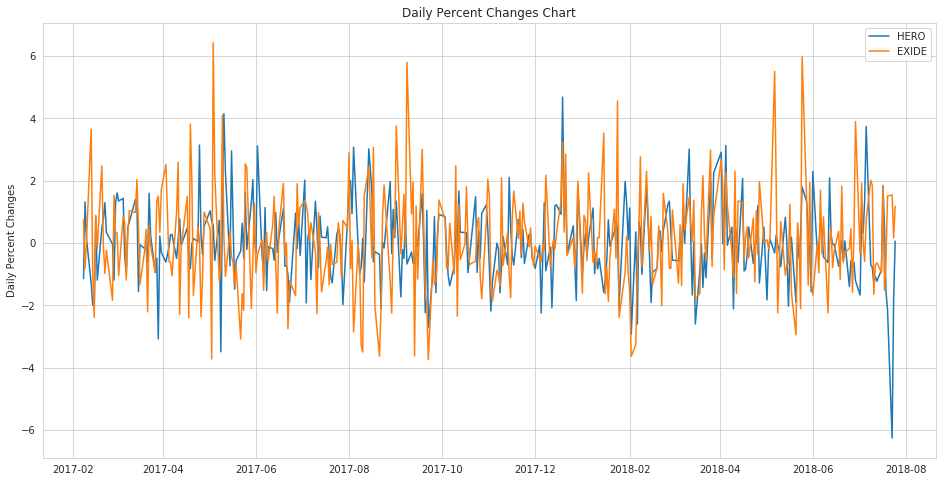

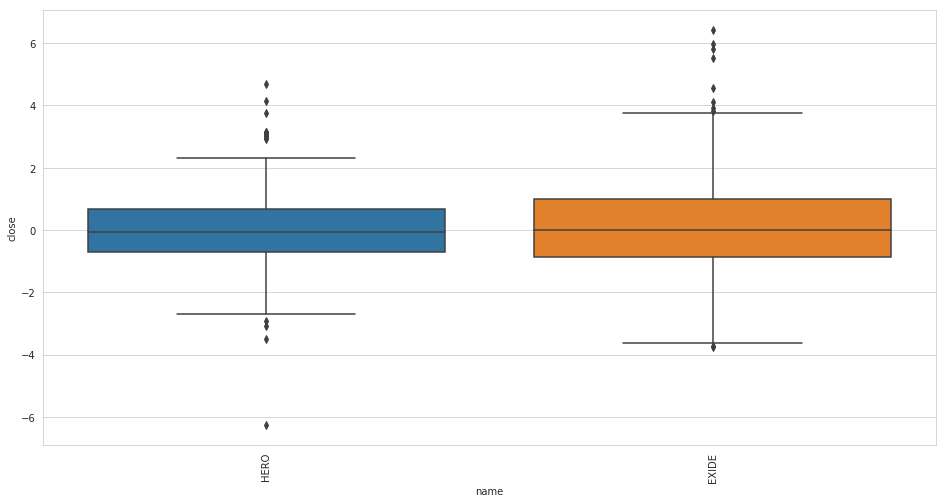

In [231]:

generate_percent_change_chart({"HERO":accumulator['HEROMOTOCO']['past_prices']['all_past_prices'],
                       "EXIDE":accumulator['EXIDEIND']['past_prices']['all_past_prices']},days=365)

#### Nifty 50, Nifty 100, Nifty midcap 50 Analysis

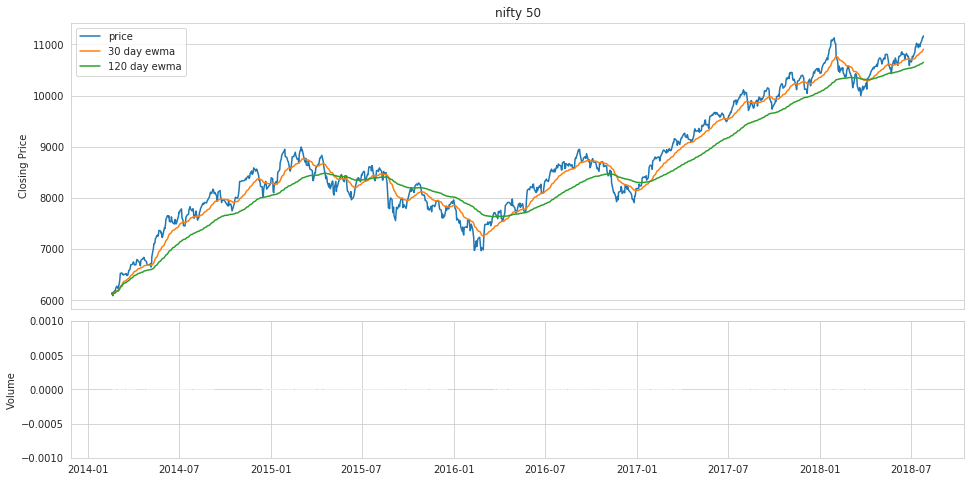

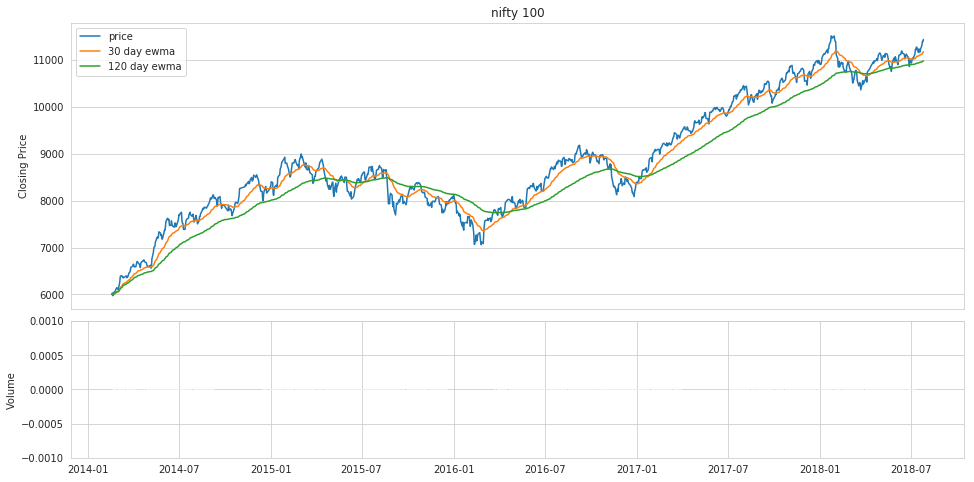

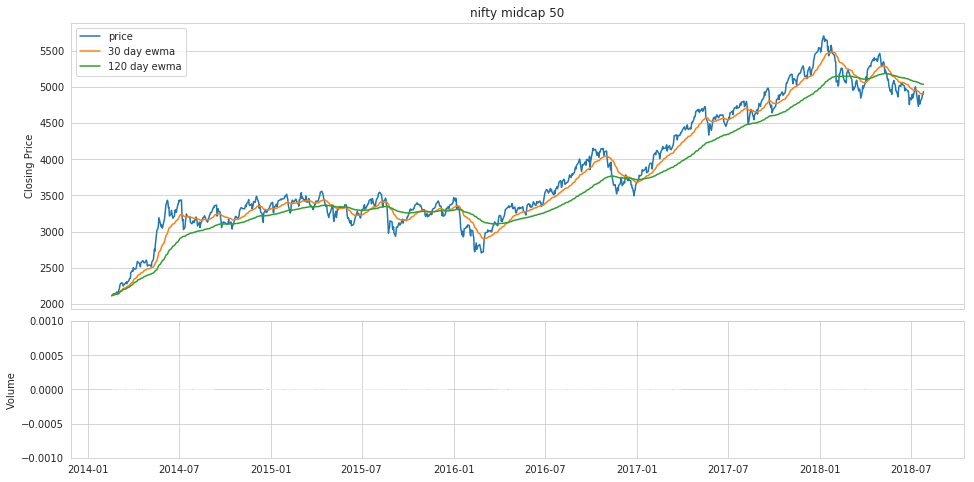

In [143]:
n50_url = "http://www.moneycontrol.com/tech_charts/nse/his/nifty.csv"
n50 = pd.read_csv(n50_url,header=None,names=['open','high','low','close','volume'])[['open','high','low','close','volume']]
n50.index = pd.to_datetime(n50.index)


n100_url = "http://www.moneycontrol.com/tech_charts/nse/his/cnx_100.csv"
n100 = pd.read_csv(n100_url,header=None,names=['open','high','low','close','volume'])[['open','high','low','close','volume']]
n100.index = pd.to_datetime(n100.index)

nmid_url = "http://www.moneycontrol.com/tech_charts/nse/his/nifty_midcap_50.csv"
nmid = pd.read_csv(nmid_url,header=None,names=['open','high','low','close','volume'])[['open','high','low','close','volume']]
nmid.index = pd.to_datetime(nmid.index)



generate_price_volume_chart(n50,"nifty 50",days=1095,ewmas=[30,120])
generate_price_volume_chart(n100,"nifty 100",days=1095,ewmas=[30,120])
generate_price_volume_chart(nmid,"nifty midcap 50",days=1095,ewmas=[30,120])


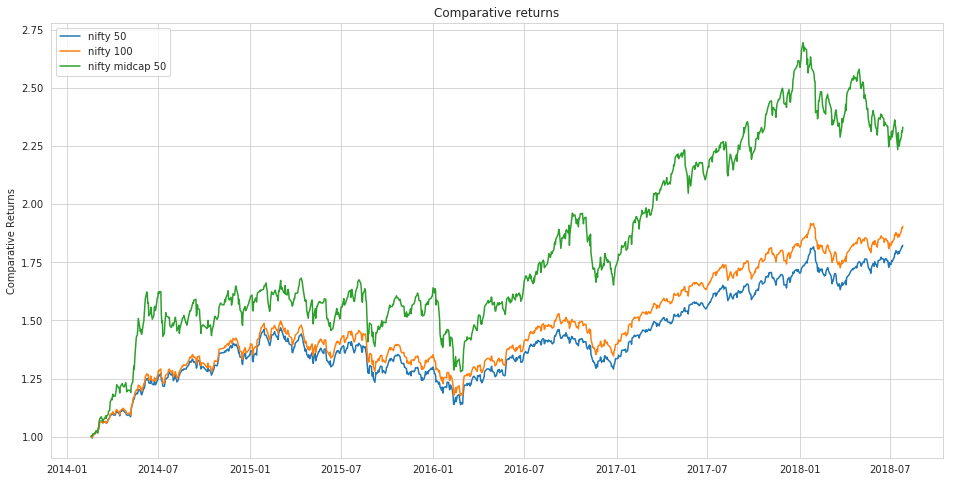

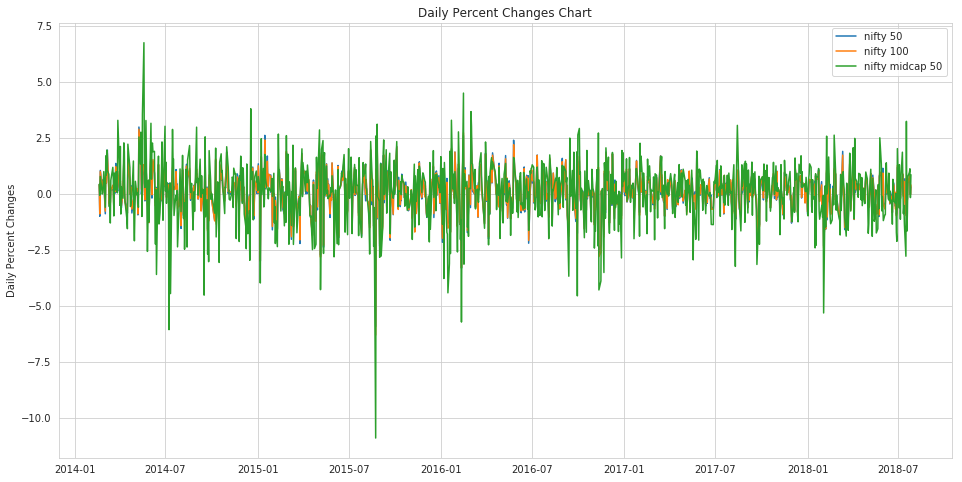

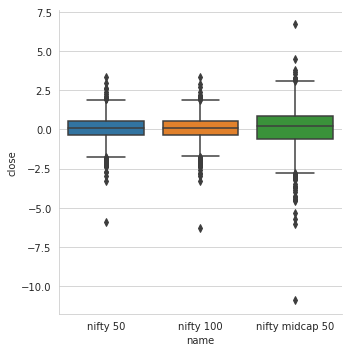

In [144]:


generate_returns_chart({"nifty 50":n50,"nifty 100":n100,"nifty midcap 50":nmid})
generate_percent_change_chart({"nifty 50":n50,"nifty 100":n100,"nifty midcap 50":nmid},days=1095)


#### Volatility vs Returns (Sharpe, alpha, beta)

### MF Analysis

In [12]:
# get avg pe and pb and deliverables
# get avg market cap
# current nav
# current aum
# last five year growth rate
# mfid = "MSB532"
# nifty MKM321 MSB1174
# Bluechip SBI MSB532

In [147]:
def get_all_details(scrip_links_table,percent_col=4,scrip_col=0,threadpool_size=8):
    scrip_details = list()
    percent_col = 4
    scrip_col = 0
    qty_col = 2
    total_value_crores_col = 3
    
    def scrip_detail_collector(row):
        scrip_url = row[scrip_col]['href']
        scrip_detail = get_scrip_info(scrip_url)
        try:
            
            scrip_detail['percent'] = row[percent_col]['text']
            scrip_detail['name'] = row[scrip_col]['text']
            scrip_detail['qty'] = row[qty_col]['text']
            scrip_detail['total_value_crores'] = row[total_value_crores_col]['text']
        except Exception as e:
            print(scrip_url)
        return scrip_detail
        
    pool = ThreadPool(threadpool_size)
    scrip_details = pool.map(scrip_detail_collector, scrip_links_table)
    scrip_details = list(filter(lambda x:x is not None,scrip_details))
    length1 = len(scrip_details)
    scrip_details = list(filter(lambda x:not x['failure'],scrip_details))
    length2 = len(scrip_details)
    print("Scrips which failed to fetch = %s"%(length1-length2))
    scrip_details = pd.DataFrame.from_records(scrip_details)
    numeric_cols = ['book_value', 'price','deliverables', 'eps', 'industry_pe', 
                    'market_cap', 'pb', 'pc', 'pe', 'percent','qty','total_value_crores',
                   'yearly_high','yearly_low','min_csg','three_year_csg','min_cpg','three_year_cpg',
                   'min_roe','three_year_roe','peg','min_recovery_year']
    scrip_details[numeric_cols] = scrip_details[numeric_cols].applymap(ffloat)
    return scrip_details

In [195]:
def fund_price_analysis(fund_list,benchmark_index_prices={},days=1095):
    fund_prices = {}
    for fund in fund_list:
        portfolio_table,fund_name = get_portfolio(mfid = fund)
        prices_df = pd.read_csv("https://www.moneycontrol.com/mf/mf_info/mf_graph.php?im_id=%s"%fund,header=None,names=['open','high','low','close','volume'])[['open','high','low','close','volume']]
        prices_df.index = pd.to_datetime(prices_df.index)
        fund_prices[fund_name] = prices_df
    generate_returns_chart({**fund_prices,**benchmark_index_prices},days=1095)
    generate_percent_change_chart({**fund_prices,**benchmark_index_prices},days=1095)
    

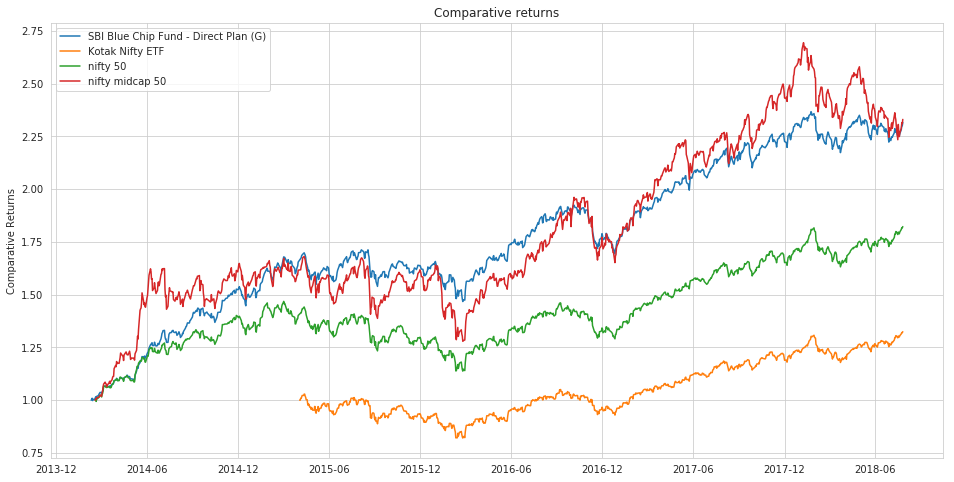

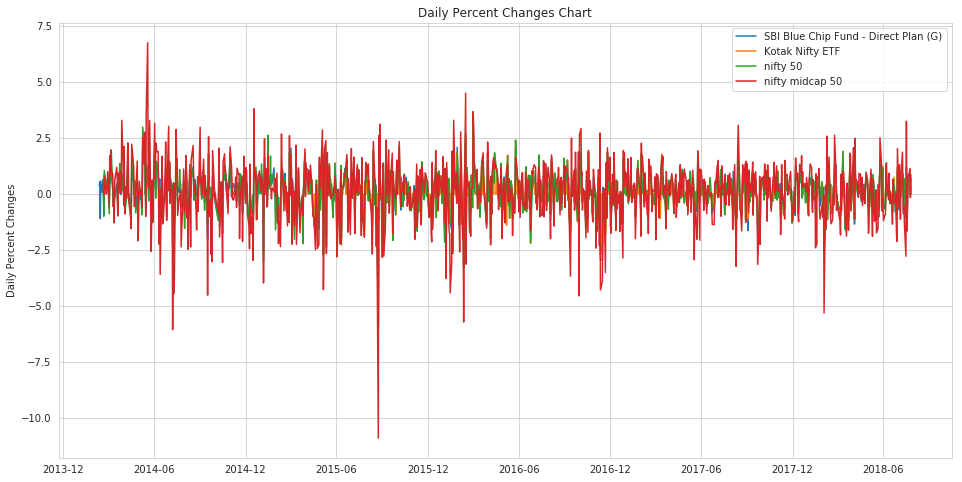

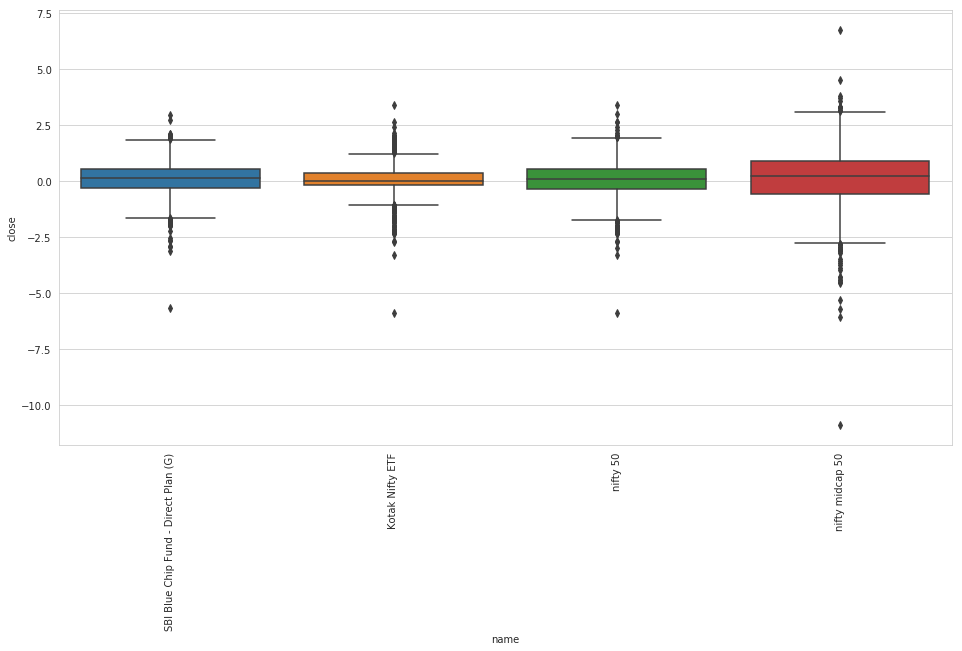

In [232]:
fund_price_analysis(['MSB532','MKM321'],{"nifty 50":n50,"nifty midcap 50":nmid})

In [182]:
def comparative_analysis(fund_list,threadpool_size=8):
    fund_details = list()
    for fund in fund_list:
        portfolio_table,fund_name = get_portfolio(mfid = fund)
        table_data = get_table(portfolio_table)
        scrip_details = get_all_details(table_data[1:],threadpool_size=threadpool_size)
        pe = np.dot(scrip_details['price'].fillna(0),scrip_details['percent'])/np.dot(scrip_details['eps'].fillna(0),scrip_details['percent'])
        three_year_cpg = np.dot(scrip_details['three_year_cpg'].fillna(0),scrip_details['percent']/100)
        peg = pe/three_year_cpg
        pb = np.dot(scrip_details['price'].fillna(0),scrip_details['percent'])/np.dot(scrip_details['book_value'].fillna(0),scrip_details['percent'])
        aum = np.sum(scrip_details['total_value_crores'])
        avg_market_cap = np.dot(scrip_details['market_cap'].fillna(0),scrip_details['percent']/100)
        min_recovery_year = get_year_when_cumulative_profit_over_pe(pe,three_year_cpg)
        prices_df = pd.read_csv("https://www.moneycontrol.com/mf/mf_info/mf_graph.php?im_id=%s"%fund,header=None,names=['open','high','low','close','volume'])[['open','high','low','close','volume']]
        prices_df.index = pd.to_datetime(prices_df.index)
        fund_detail = {"name":fund_name,"pe":pe,"peg":peg,"pb":pb,"aum":aum,"avg_market_cap":avg_market_cap,"three_year_cpg":three_year_cpg,"min_recovery_year":min_recovery_year,"past_prices":prices_df}
        fund_details.append(fund_detail)
    return pd.DataFrame.from_records(fund_details)


In [ ]:
comparative_analysis(['MSB532','MKM321'],threadpool_size=128)

### References

- https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/
- https://mapattack.wordpress.com/2017/02/14/python-for-stocks-2/

more involved articles:

 - https://ntguardian.wordpress.com/2018/07/17/stock-data-analysis-python-v2/
 - https://nextjournal.com/hisham/stock-market
 